# Copyright Netherlands eScience Center <br>
**Function     : Train BayesLSTM model with multiple layers ** <br>
**Author       : Yang Liu** <br>
**First Built  : 2021.05.02** <br>
**Last Update  : 2021.05.02** <br>
**Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, dlacs, matplotlib** <br>
**Description  : This notebook serves to predict the Lorenz 84 model using deep learning. The
                 Bayesian Long Short Time Memory neural network is used to deal with this
                 spatial-temporal sequence problem.** <br>
                 We use Pytorch as the deep learning framework.<br>
Return Values   : pkl model and figures <br>

In [1]:
import sys
import warnings
import numbers
import logging
import time as tttt

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import sklearn
#import scipy
import torch
import torch.nn.functional

#sys.path.append("../")
sys.path.append("H:\\Creator_Zone\\Script_craft\\ML4Climate\\Scripts\\DLACs")
import dlacs
import dlacs.BayesConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF
import dlacs.metric

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

# ignore all the DeprecationWarnings by pytorch
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2500000,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

In [3]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
# please specify data path
# datapath for output
output_path = 'H:\\Creator_Zone\\Script_craft\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\epoch3000_p100000_stdx4_layer5'
model_path = 'H:\\Creator_Zone\\Script_craft\\ML4Climate\\PredictArctic\\BayesMaps\\Lorenz84\\bayes\\fullseries_ex\\epoch3000_p100000_stdx4_layer5\\base'
################################################################################# 
#########                             main                               ########
#################################################################################
# set up logging files
logging.basicConfig(filename = os.path.join(output_path,'logFile_Lorenz84_train_ex.log'),
                    filemode = 'w+', level = logging.DEBUG,
                    format = '%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logging.getLogger('matplotlib.font_manager').disabled = True

In [4]:
if __name__=="__main__":
    print ('*********************** get the key to the datasets *************************')
    #################################################################################
    ###########                configure Lorenz 84 model                  ###########
    #################################################################################
    logging.info("Configure Lorenz 84 model")
    # Lorenz paramters and initial conditions
    x_init = 1.0 # strength of the symmetric globally encircling westerly current
    y_init = 1.0 # strength of the cosine phases of a chain of superposedwaves (large scale eddies)
    z_init = 1.0 # strength of the sine phases of a chain of superposedwaves (large scale eddies)
    F = 8.0 # thermal forcing term
    G = 1.0 # thermal forcing term
    epsilon = 0.4 # intensity of periodic forcing
    a = 0.25 # stiffness factor for westerly wind x
    b = 4.0 # advection strength of the waves by the westerly current
    
    # assuming the damping time for the waves is 5 days (Lorens 1984)
    dt = 0.0333 # 1/30 unit of time unit (5 days)
    num_steps = 1500
    # cut-off point of initialization period
    cut_off = 0
    
    logging.info("#####################################")
    logging.info("Summary of Lorenz 84 model")
    logging.info("x = 1.0  y = 1.0  z = 1.0")
    logging.info("F = 8.0 G = 1.0 a = 0.25 b = 4.0")
    logging.info("epsilon = 0.4")
    logging.info("unit time step 0.0333 (~5days)")
    logging.info("series length 1500 steps")
    logging.info("cut-off length 0 steps")    
    logging.info("#####################################")

*********************** get the key to the datasets *************************


In [5]:
    #################################################################################
    ###########            Lorens 84 model + periodic forcing             ###########
    #################################################################################
    def lorenz84_ex(x, y, z, t, a = 0.25, b = 4.0, F = 8.0, G = 1.0, epsilon = 1.0):
        """
        Solver of Lorens-84 model with periodic external forcing.
        
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        
        The model is designed with a reference to the paper:
        Broer, H., Simó, C., & Vitolo, R. (2002). Bifurcations and strange
        attractors in the Lorenz-84 climate model with seasonal forcing. Nonlinearity, 15(4), 1205.
        
        Song, Y., Yu, Y., & Wang, H. (2011, October). The stability and chaos analysis of the
        Lorenz-84 atmosphere model with seasonal forcing. In 2011 Fourth International Workshop
        on Chaos-Fractals Theories and Applications (pp. 37-41). IEEE.
        """
        # each time step is ~ 5days, therefore the returning period are 365 / 5 = 73 times in a year
        T = 73
        omega = 2 * np.pi / T
        dx = - y**2 - z**2 - a * x + a * F * (1 + epsilon * np.cos(omega * t))
        dy = x * y - b * x * z - y + G * (1 + epsilon * np.sin(omega * t))
        dz = b * x * y + x * z - z
        
        return dx, dy, dz

In [6]:
    #################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing       ###########
    #################################################################################
    logging.info("Launch Lorenz 84 model")
    # Need one more for the initial values
    x = np.empty(num_steps)
    y = np.empty(num_steps)
    z = np.empty(num_steps)
    t = 0.0
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps-1):
        dx, dy, dz = lorenz84_ex(x[i], y[i], z[i], t, a, b ,F, G, epsilon)
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)
        t += dt

In [7]:
    #################################################################################
    ###########        Prepare Lorenz 84 model output for learning        ###########
    #################################################################################
    # time series cut-off
    if cut_off:
        x = x[cut_off:]
        y = y[cut_off:]
        z = z[cut_off:]
    print ('===================  normalize data  =====================')
    x_norm = dlacs.preprocess.operator.normalize(x)
    y_norm = dlacs.preprocess.operator.normalize(y)
    z_norm = dlacs.preprocess.operator.normalize(z)
    print('================  save the normalizing factor  =================')
    x_max = np.amax(x)
    x_min = np.amin(x)
    y_max = np.amax(y)
    y_min = np.amin(y)
    z_max = np.amax(z)
    z_min = np.amin(z)
    logging.info("Data preprocessing complete!")

===================  normalize data  =====================
================  save the normalizing factor  =================


In [8]:
    #################################################################################
    ###########      create basic dimensions for tensor and network       ###########
    #################################################################################
    print ('*******************  create basic dimensions for tensor and network  *********************')
    # specifications of neural network
    input_channels = 3
    #hidden_channels = [3, 2, 1] # number of channels & hidden layers, the channels of last layer is the channels of output, too
    hidden_channels = [3, 3, 3, 3, 3]
    kernel_size = 1
    # here we input a sequence and predict the next step only
    #step = 1 # how many steps to predict ahead
    #effective_step = [0] # step to output
    batch_size = 1
    #num_layers = 1
    learning_rate = 0.01
    num_epochs = 800
    print ('*******************  testing data  *********************')
    test_len = 200
    print ('*******************  check the environment  *********************')
    print ("Pytorch version {}".format(torch.__version__))
    # check if CUDA is available
    #use_cuda = torch.cuda.is_available()
    #print("Is CUDA available? {}".format(use_cuda))
    #logging.info("Is CUDA available? {}".format(use_cuda))
    # CUDA settings torch.__version__ must > 0.4
    # !!! This is important for the model!!! The first option is gpu
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device = torch.device("cpu")

*******************  create basic dimensions for tensor and network  *********************
*******************  testing data  *********************
*******************  check the environment  *********************
Pytorch version 1.1.0


In [9]:
    #################################################################################
    ###########              create the BayesConvLSTM model               ###########
    #################################################################################
    print ('*******************  run BayesConvLSTM  *********************')
    print ('The model is designed to make many to one prediction.')
    print ('A series of multi-chanel variables will be input to the model.')
    print ('The model learns by verifying the output at each timestep.')
    # check the sequence shape
    sequence_len = num_steps - cut_off
    height = 1
    width = 1
    # initialize our model
    model = dlacs.BayesConvLSTM.BayesConvLSTM(input_channels, hidden_channels, kernel_size).to(device)
    # use Evidence Lower Bound (ELBO) to quantify the loss
    ELBO = dlacs.function.ELBO(height*width)
    # penalty for kl
    penalty_kl = 100000
    # stochastic gradient descent
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Adam optimizer
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(model)
    print(ELBO)
    print(optimiser)

*******************  run BayesConvLSTM  *********************
The model is designed to make many to one prediction.
A series of multi-chanel variables will be input to the model.
The model learns by verifying the output at each timestep.
!@#$% The network will be built with reduced size BayesConvLSTM cell. !@#$%
BayesConvLSTM(
  (cell0): BayesConvLSTMCell()
  (cell1): BayesConvLSTMCell()
  (cell2): BayesConvLSTMCell()
  (cell3): BayesConvLSTMCell()
  (cell4): BayesConvLSTMCell()
)
ELBO(
  (loss_function): MSELoss()
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


In [16]:
    #################################################################################
    ###########              load existed BayesConvLSTM model             ###########
    #################################################################################
    print ('*******************  load exsited ConvLSTM model  *********************')
    model.load_state_dict(torch.load(os.path.join(model_path, 'bayesconvlstm_lorenz84_ex_epoch_0_1000_base.pkl'),
                                map_location=device))

*******************  load exsited ConvLSTM model  *********************


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [18]:
    # calculate the time for the code execution
    start_time = tttt.time()       
    print('##############################################################')
    print('##################  start training loop  #####################')
    print('##############################################################')
    # track training loss
    hist = np.zeros(num_epochs)
    hist_likelihood = np.zeros(num_epochs)
    hist_complexity = np.zeros(num_epochs)
    # loop of epoch
    for t in range(num_epochs):
        # Clear stored gradient
        model.zero_grad()
        # loop of timestep
        for timestep in range(sequence_len - test_len):
            # hidden state re-initialized inside the model when timestep=0
            #################################################################################
            ########          create input tensor with multi-input dimension         ########
            #################################################################################
            # create variables
            x_input = np.stack((x_norm[timestep], y_norm[timestep], z_norm[timestep])) #vstack,hstack,dstack
            x_var = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width)).to(device)
            #################################################################################
            ########       create training tensor with multi-input dimension         ########
            #################################################################################
            y_train_stack = np.stack((x_norm[timestep+1], y_norm[timestep+1], z_norm[timestep+1])) #vstack,hstack,dstack
            y_var = torch.autograd.Variable(torch.Tensor(y_train_stack).view(-1,hidden_channels[-1],height,width)).to(device)
            #################################################################################   
            # Forward pass
            y_pred, kl_loss, _ = model(x_var, timestep)
            # choose training data
            y_target = y_var
            # torch.nn.functional.mse_loss(y_pred, y_train) can work with (scalar,vector) & (vector,vector)
            # Please Make Sure y_pred & y_train have the same dimension
            # accumulate loss
            if timestep == 0:
                loss, likelihood, complexity = ELBO(y_pred, y_target, kl_loss,
                                                    1 / (len(hidden_channels) * 8 * penalty_kl * kernel_size**2))
            else:
                loss_step, likelihood_step,\
                complexity_step = ELBO(y_pred, y_target, kl_loss,
                                       1 / (len(hidden_channels) * 8 * penalty_kl * kernel_size**2))
                loss += loss_step
                likelihood += likelihood_step
                complexity += complexity_step
        #print(y_pred.shape)
        #print(y_train.shape)
        # print loss at certain iteration
        if t % 10 == 0:
            print("Epoch {} ELBO: {:0.3f}".format(t, loss.item()))
            logging.info("Epoch {} MSE: {:0.3f}".format(t,loss.item()))
            print("likelihood cost {:0.3f} #*# complexity cost {:0.3f}".format(likelihood.item(), complexity.item()))
            logging.info("likelihood cost {:0.3f} #*# complexity cost {:0.3f}".format(likelihood.item(), complexity.item()))
            print("=========================================")
            logging.info("==========================================")
            # gradient check
            # Gradcheck requires double precision numbers to run
            #res = torch.autograd.gradcheck(loss_fn, (y_pred.double(), y_train.double()), eps=1e-6, raise_exception=True)
            #print(res)
        hist[t] = loss.item()
        hist_likelihood[t] = likelihood.item()
        hist_complexity[t] = complexity.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()
    
        # Backward pass
        loss.backward()

        # Update parametersdd
        optimiser.step()
        
    # save the model
    # (recommended) save the model parameters only
    torch.save(model.state_dict(), os.path.join(output_path,'bayesconvlstm_lorenz84_ex.pkl'))
    
    print ("--- %s minutes ---" % ((tttt.time() - start_time)/60))
    logging.info("--- %s minutes ---" % ((tttt.time() - start_time)/60))

##############################################################
##################  start training loop  #####################
##############################################################
Epoch 0 ELBO: 10.710
likelihood cost 10.622 #*# complexity cost 0.089


KeyboardInterrupt: 

*******************  Loss with time  **********************
*******************  Loss with time (log)  **********************


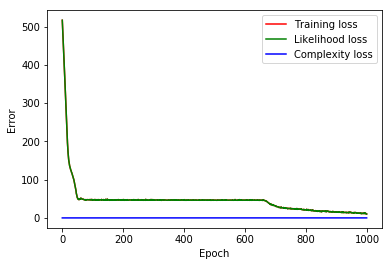

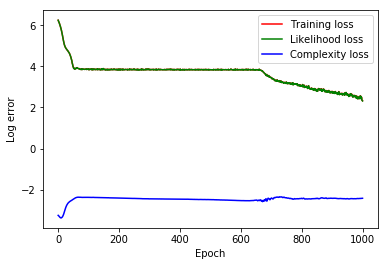

In [13]:
    #################################################################################
    ###########                 after training statistics                 ###########
    #################################################################################
    print ("*******************  Loss with time  **********************")
    fig00 = plt.figure()
    plt.plot(hist, 'r', label="Training loss")
    plt.plot(hist_likelihood, 'g', label="Likelihood loss")
    plt.plot(hist_complexity, 'b', label="Complexity loss")
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    fig00.savefig(os.path.join(output_path,'BayesConvLSTM_pred_error_Lorenz84_ex.png'),dpi=150)
    
    print ("*******************  Loss with time (log)  **********************")
    fig01 = plt.figure()
    plt.plot(np.log(hist), 'r', label="Training loss")
    plt.plot(np.log(hist_likelihood), 'g', label="Likelihood loss")
    plt.plot(np.log(hist_complexity), 'b', label="Complexity loss")
    plt.xlabel('Epoch')
    plt.ylabel('Log error')
    plt.legend()
    plt.show()
    fig01.savefig(os.path.join(output_path,'BayesConvLSTM_pred_log_error_Lorenz84_ex.png'),dpi=150)